# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [19]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

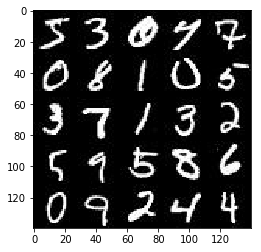

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

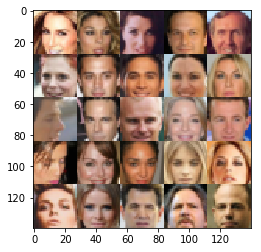

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [23]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_height,image_width,image_channels),name='real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    lr_rate = tf.placeholder(tf.float32,name='lr_rate') 
    
    
    return real_input, z_input, lr_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #input_shape is 28*28*3
        conv1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(conv1*0.01,conv1)
        drop1 = tf.nn.dropout(relu1,0.7)
        #14*14*64
        conv2 = tf.layers.conv2d(drop1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2,training=True)
        relu2 = tf.maximum(bn2*0.01,conv2)
        drop2 = tf.nn.dropout(relu2,0.7)
        #7*7*128
        conv3 = tf.layers.conv2d(drop2,256,3,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(conv3,training=True)
        relu3 = tf.maximum(bn3*0.01,conv3)
        drop3 = tf.nn.dropout(relu3,0.7)
        #7*7*256
        flatten = tf.reshape(drop3,(-1,7*7*256))
        logits = tf.layers.dense(flatten,1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(x1*0.01,x1)
        
        x2 = tf.layers.conv2d_transpose(x1,256,3,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(x2*0.01,x2)
        x2 = tf.nn.dropout(x2,0.7)
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(x3*0.01,x3)
        x3 = tf.nn.dropout(x3,0.7)
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=2,padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())

        output = tf.tanh(logits)
        
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_real)*0.9,logits=d_logits_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_logits_fake),logits=d_logits_fake))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_fake),logits=d_logits_fake))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
  
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input,z_input,lr_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss = model_loss(real_input,z_input,data_shape[-1])
    d_opt,g_opt = model_opt(d_loss,g_loss,learning_rate,beta1)
    


    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
#           I have changed the 'get_batches' function in helper for the batch_images outputby multiply 2
                _ = sess.run(d_opt,{z_input:batch_z,lr_rate:learning_rate,real_input:batch_images*2})
                _ = sess.run(g_opt,{z_input:batch_z,lr_rate:learning_rate})
        
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images*2})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess,16,z_input,data_shape[-1],data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8396... Generator Loss: 1.3915
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.9251
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 0.5428


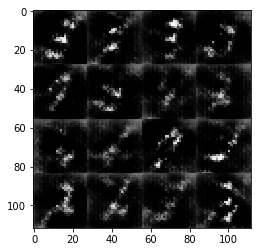

Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.9595
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.5654
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.8694
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 0.6660


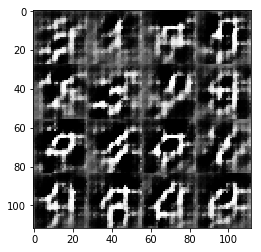

Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.7010


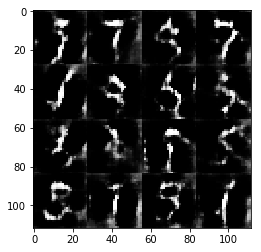

Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.6905


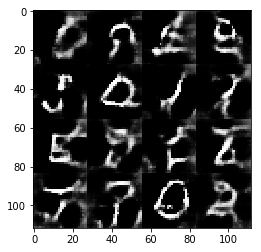

Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 1.1740
Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.8658
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 0.8250


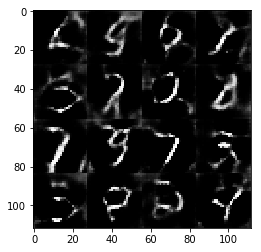

Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 1.0844
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 1.0315
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.7219
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.9227


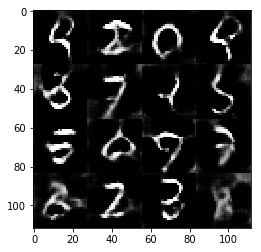

Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.9483
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.9621


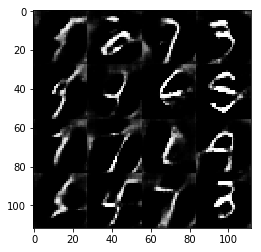

Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.9619


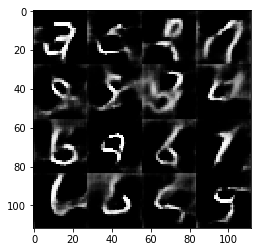

Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.9290
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 1.2035


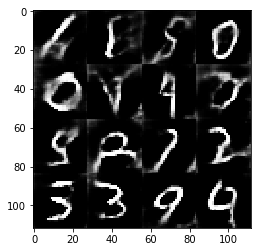

Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 1.0482
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 1.0378
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 0.9102


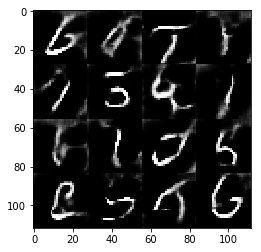

Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 1.6554... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.8515


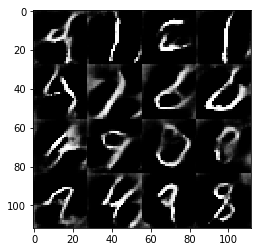

Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.9478
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 0.9748


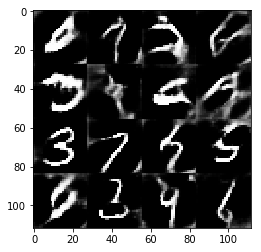

Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 0.9264
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 1.0106
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 0.8428


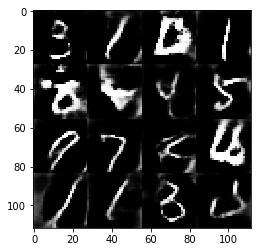

Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.9318
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 1.0016
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.8575


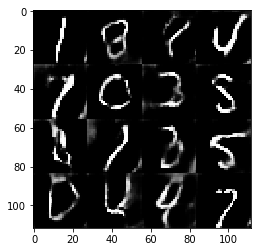

Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.0239
Epoch 1/2... Discriminator Loss: 1.2008... Generator Loss: 1.0381


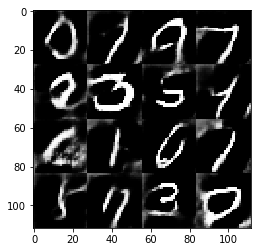

Epoch 1/2... Discriminator Loss: 1.1260... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 1.1573
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 1.2767
Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 0.8643


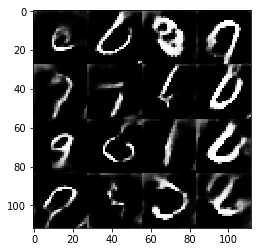

Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 1.2473
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.3793
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 1.0303


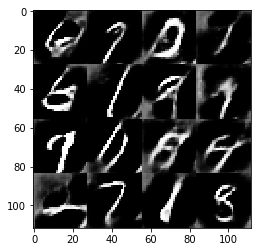

Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 2.1640
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 1.3519
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.1770


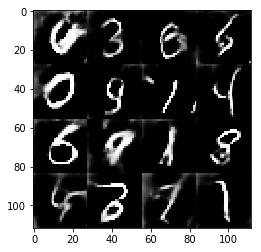

Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 1.2662
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 1.0018
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.9284
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 0.8938


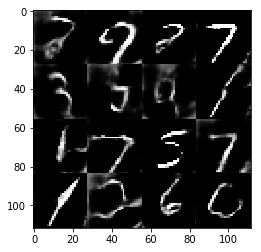

Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.9138


KeyboardInterrupt: 

In [38]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.3572


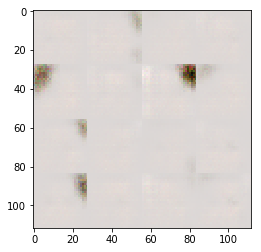

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 2.2049... Generator Loss: 0.2224
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.9998


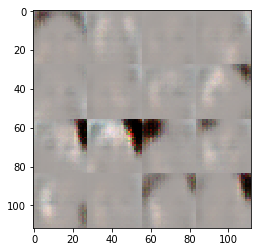

Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8196


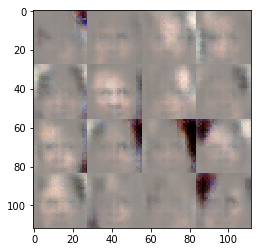

Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7017


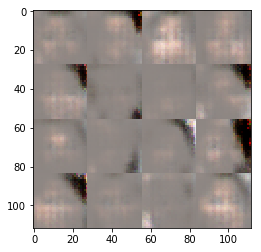

Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 1.5165
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.1234


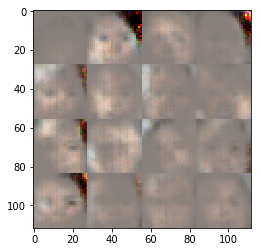

Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.0184


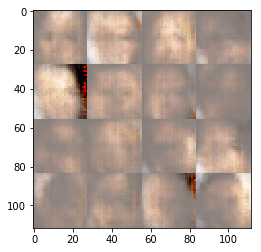

Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.2045


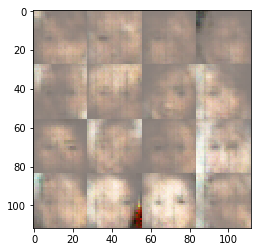

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8099


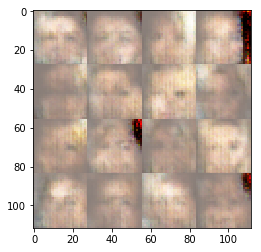

Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6032


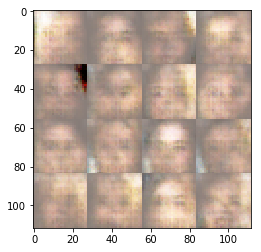

Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 1.6085
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.8279... Generator Loss: 1.5269


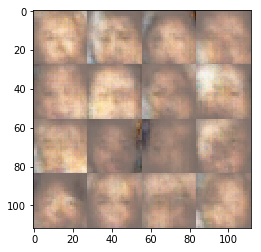

Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0095


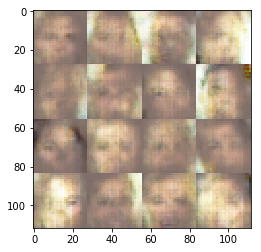

Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.4488
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.9352


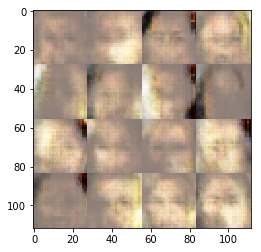

Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.5362


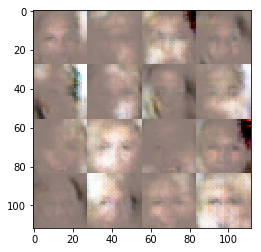

Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7949


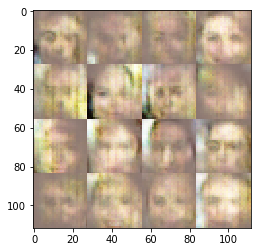

Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8360


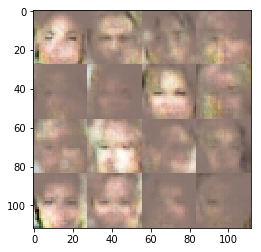

Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.1461


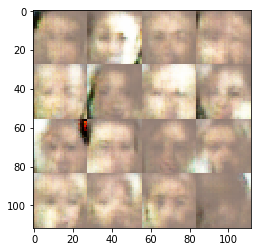

Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 1.8133
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8457


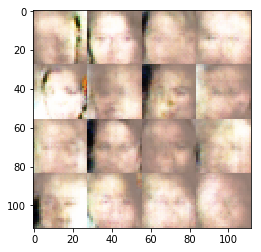

Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 3.6027


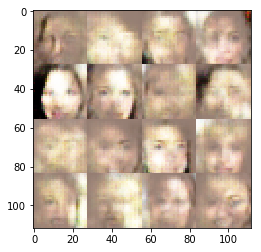

Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.8633


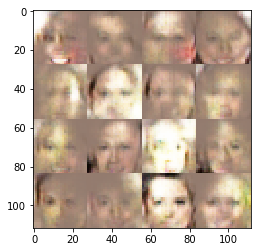

Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 2.1990... Generator Loss: 1.8043
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.6744


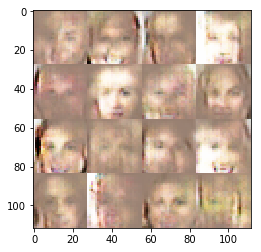

Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.7810... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 1.0955


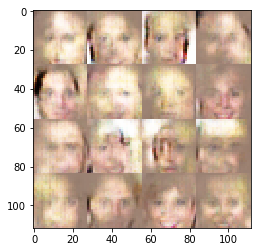

Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.4349
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7725


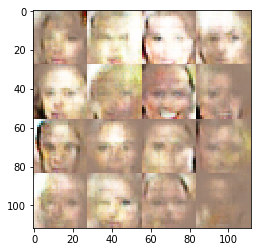

Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 2.0835


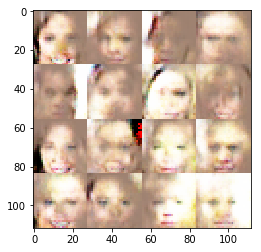

Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.4530
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.6879


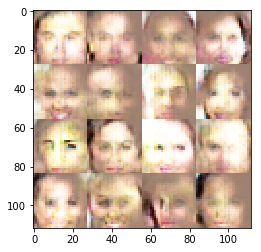

Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.0786


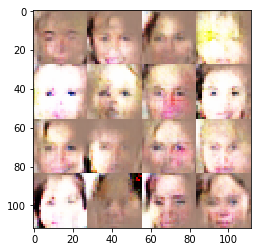

Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 2.1071
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.5911
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 2.6165
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.7063


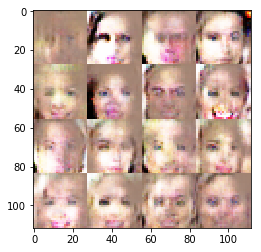

Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.0626


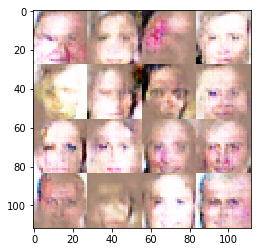

Epoch 1/1... Discriminator Loss: 1.6883... Generator Loss: 2.3026
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.7813
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.6038
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 2.5882


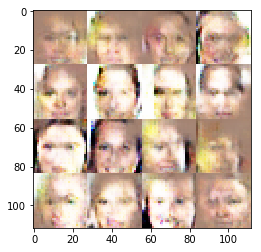

Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 2.4860
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.2831


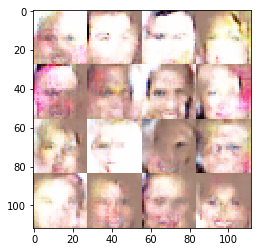

Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 2.2744... Generator Loss: 2.6714
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 1.5645
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.4312


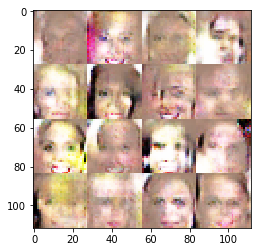

Epoch 1/1... Discriminator Loss: 1.8687... Generator Loss: 2.2380
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.1200


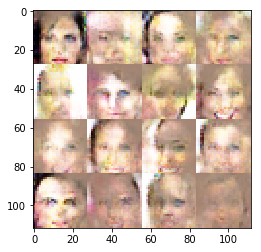

Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.8039


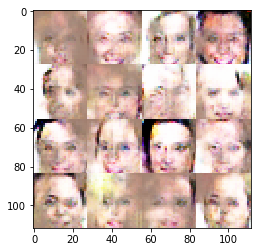

Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 2.2221
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.4115
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.7193
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 2.4682
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 1.7679


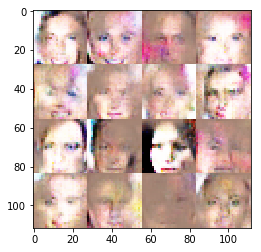

Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.3108


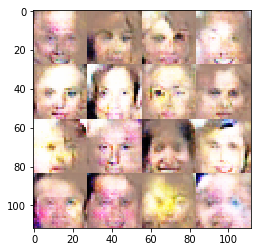

Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.3056
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 2.2128
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 1.2035


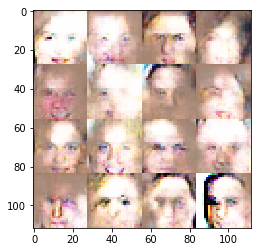

Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.6701
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 2.8434


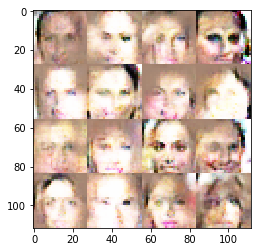

Epoch 1/1... Discriminator Loss: 1.9542... Generator Loss: 0.2482
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.8699


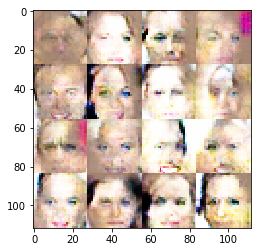

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 2.1537
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.9973


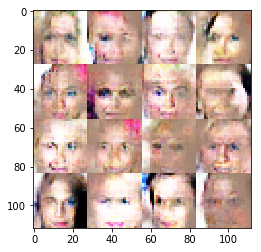

Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.8240
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 1.8290
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.3662


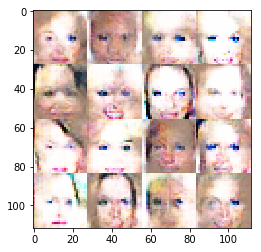

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 1.8261
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 2.1478
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.8080


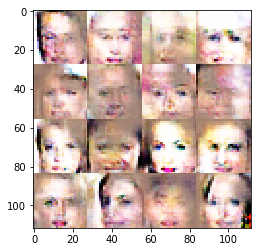

Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 2.0182
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.1796


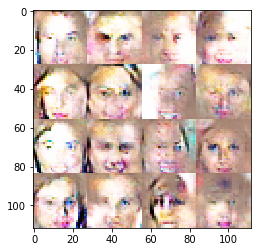

Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 2.6447
Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.7159
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.5897
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7024


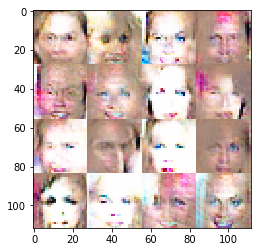

Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.4363
Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 1.8438
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.9905


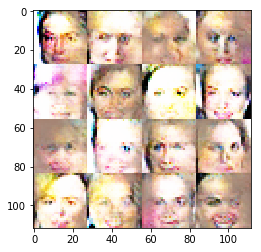

Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.3114
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 2.0811
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 1.5203
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.3482


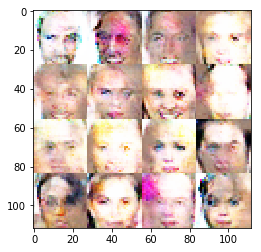

Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.5445
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 2.6566
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 1.2613


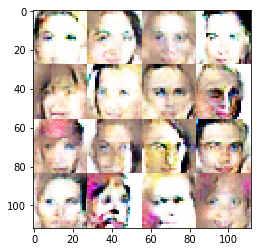

Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.7830
Epoch 1/1... Discriminator Loss: 3.0463... Generator Loss: 2.7930
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 2.5697
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.7633
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.9501


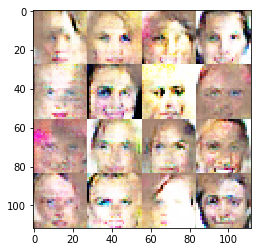

Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 2.4859


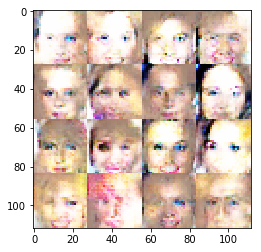

Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 1.3126
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6112


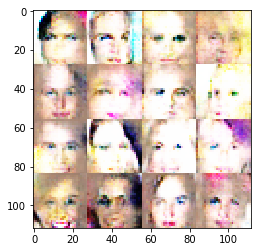

Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.7121
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 3.2542
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.6709


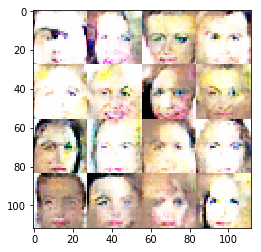

Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 2.9924
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.6625
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.8262


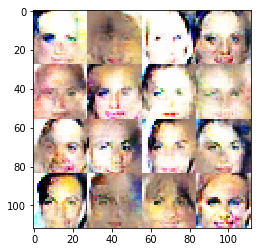

Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 2.7174
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.5061
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.7785... Generator Loss: 2.1752


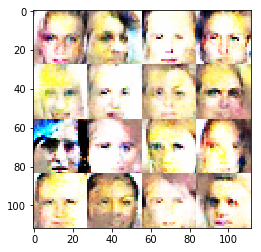

Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 1.6928
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.9267
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.1701


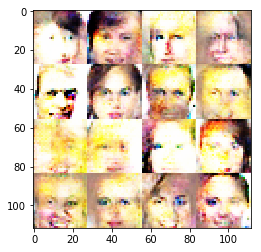

Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.3780
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 1.5807
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.7826


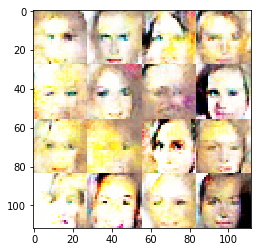

Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 2.2387... Generator Loss: 0.2292
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.0347


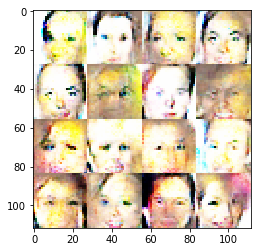

Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.6231
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.6277
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.6315


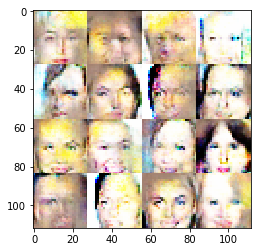

Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.7403
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.8939
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 2.3809


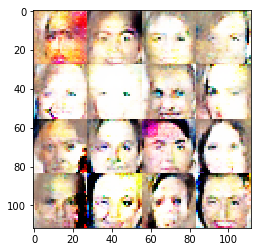

Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 2.0415
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 2.7356


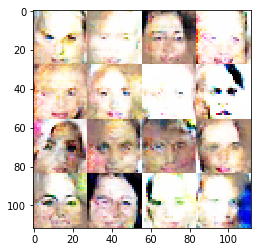

Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.8136
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 2.1561


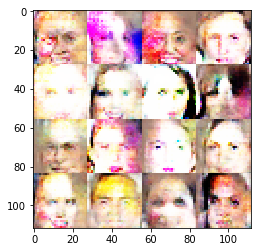

Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 2.3906
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 2.3688
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.3644


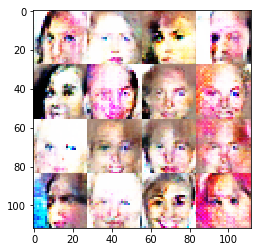

Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.6371
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.7359


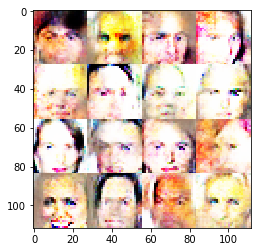

Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.2861
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.3757
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.5125
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.9388


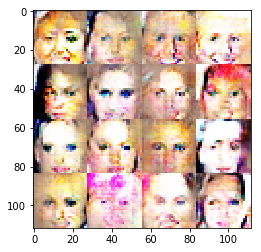

Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 2.4612
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 2.5642
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.8704


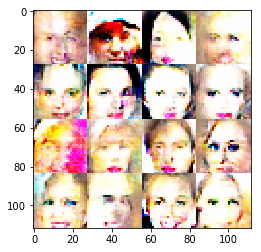

Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.0846


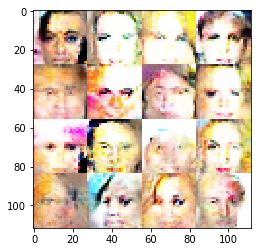

Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 1.8957
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 2.7518
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.2290


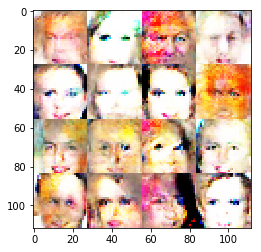

Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 2.4002
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 2.5238
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9969


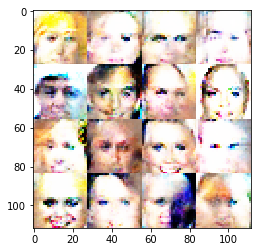

Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 2.0217
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 2.1055
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.0743


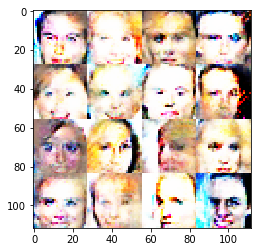

Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.6104
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 0.8696


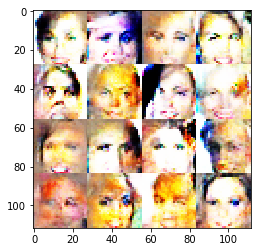

Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.5009


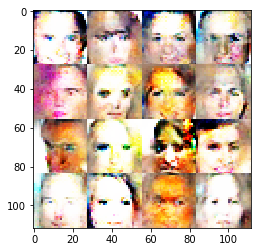

Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.9926
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.8154


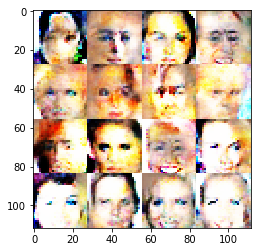

Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.9683
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.2793
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 1.3260


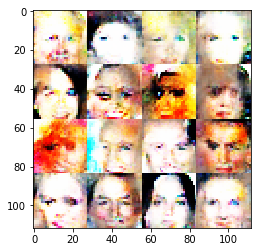

Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 2.1551
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.6716


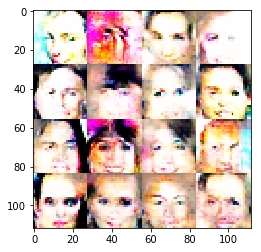

Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 2.4136
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 0.6625


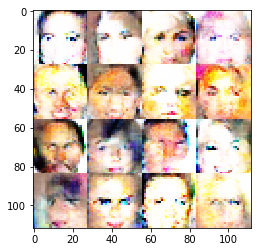

Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 2.4407
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.6992


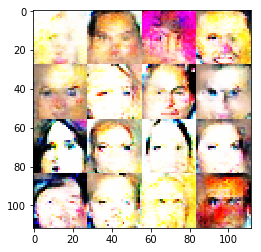

Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.4375


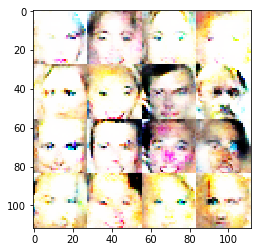

Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.2529


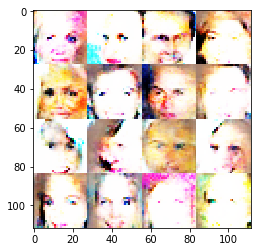

Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.4977
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.8178... Generator Loss: 3.3087
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.7467


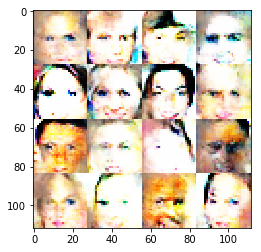

Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 3.5796
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 3.8079
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.5589


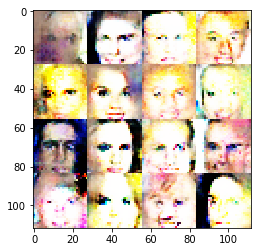

Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 2.9077
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.6752


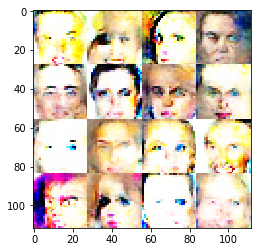

Epoch 1/1... Discriminator Loss: 1.6270... Generator Loss: 2.6633
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 1.5297


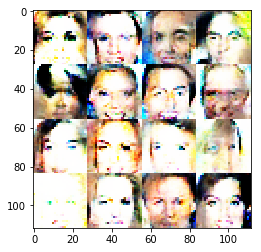

Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.1904
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.6760


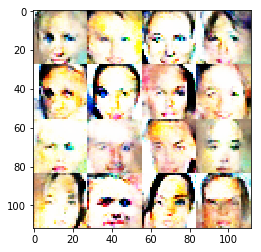

Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.5129
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 2.1054
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 2.9910... Generator Loss: 0.4340


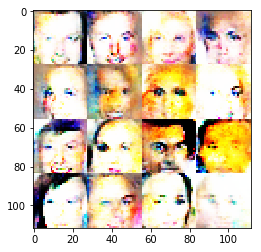

Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 2.5012... Generator Loss: 0.2990
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 2.3320
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 2.7435
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 2.4714


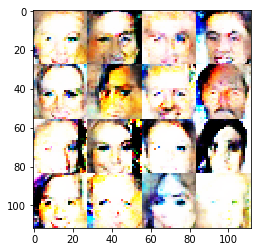

Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 2.3973
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 2.8070
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 3.3575


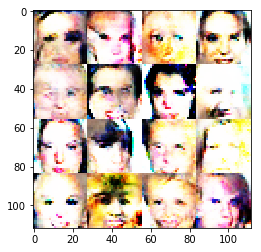

Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.6738
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 3.6227
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.4800
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 0.5431


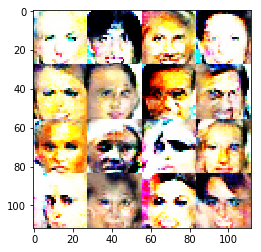

Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 1.8476
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.8363
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 1.8409
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.4461


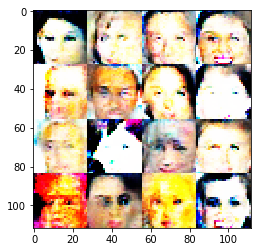

Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 2.5285
Epoch 1/1... Discriminator Loss: 2.1237... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 1.9566


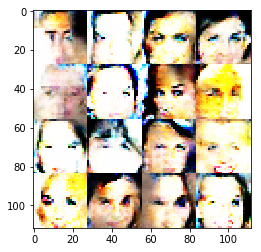

Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 1.6754
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 2.6337
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9672


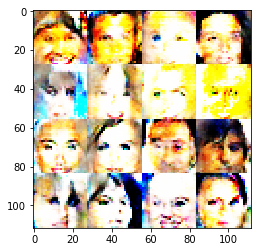

Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.8393


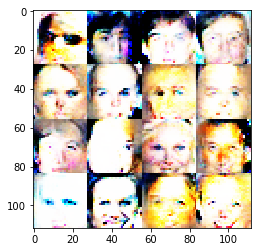

Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.5709
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.3515


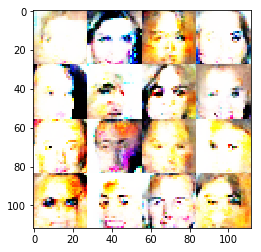

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.9189
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 1.7408... Generator Loss: 1.2383
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.8337
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.6729


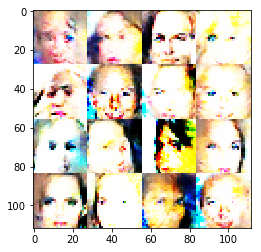

Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 2.5568
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.9745
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.4805


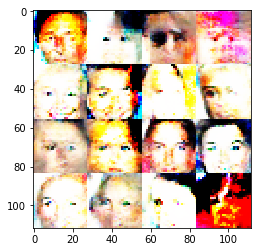

Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.3762
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 2.5014
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 2.2898


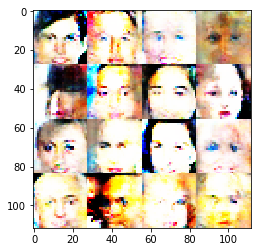

Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 2.8131
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.1234
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.2565
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 2.0950
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 2.1460


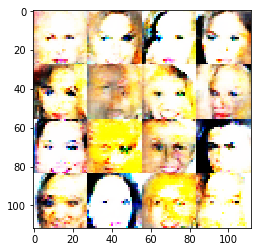

Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 2.4403
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.6269
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.7713


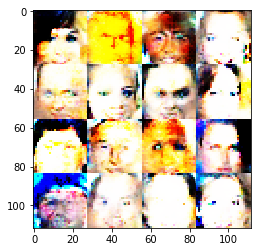

Epoch 1/1... Discriminator Loss: 0.6870... Generator Loss: 2.2053
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 2.1829
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.7344
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.9168


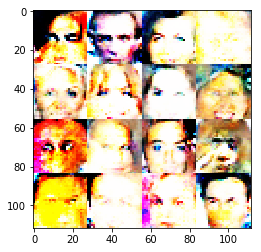

Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.5258
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.7763


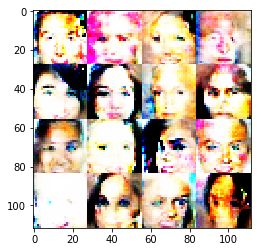

Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 2.1932
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.3375
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.2698


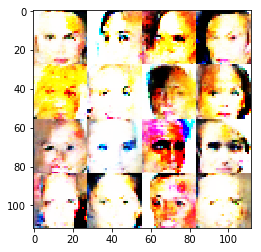

Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 2.2325
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.6689
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 1.1444


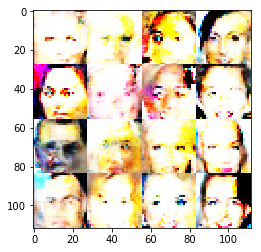

Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 2.3237
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 2.1444
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 1.1330


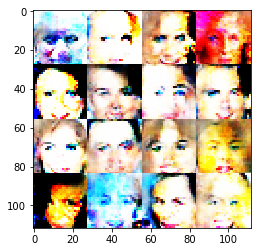

Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 2.1986
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.0755


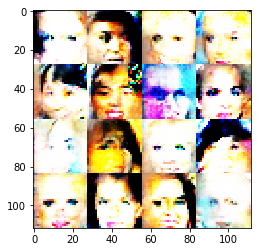

Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.8932
Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 2.1683
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.8799
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.9470
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 2.0189


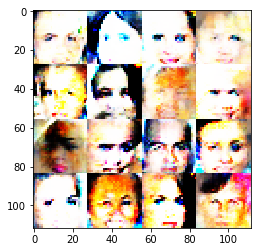

Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.6976
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.9536
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.2153


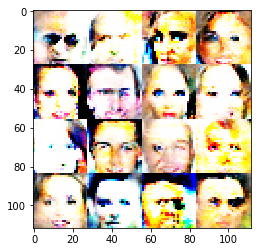

Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 2.2235
Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 1.9638


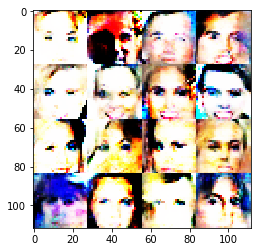

Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.0304
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.8011
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.2385
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.3651


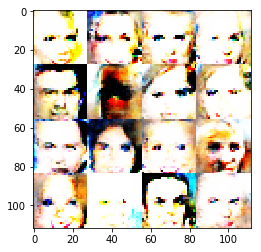

Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.8430
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.8518
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 2.5525


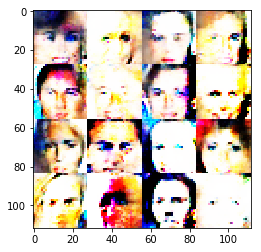

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 2.0828
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 2.3767
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.2341


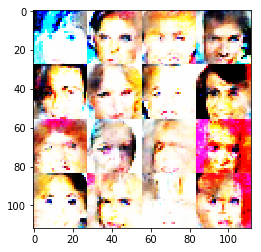

Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.4838
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 2.0355


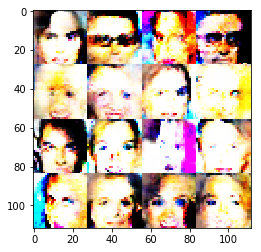

Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.7500
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.7569
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.9252
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 1.0482


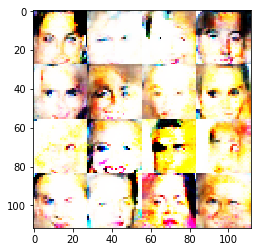

Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.7147
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 2.3356
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.9330
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.4793


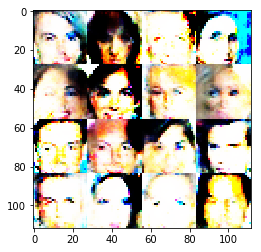

Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.8012
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 2.2442
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.0179


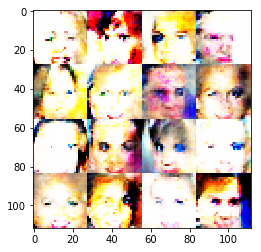

Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.4670
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 2.3011
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.7784
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.8694


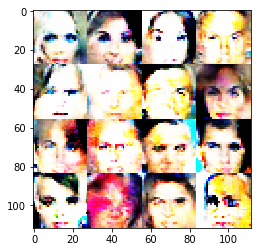

Epoch 1/1... Discriminator Loss: 1.9068... Generator Loss: 2.8017
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 2.7475
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 2.3015
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.6420


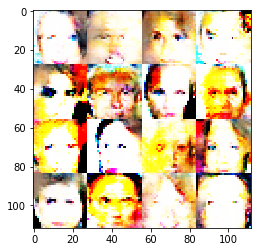

Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.5421
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 2.6167
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.7618


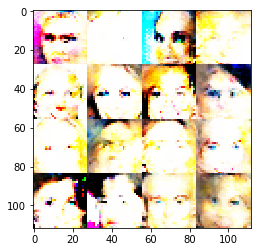

Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 2.0728
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 3.2222
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.4258


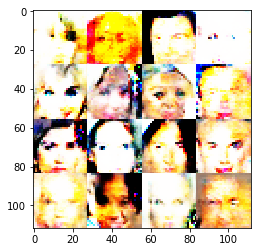

Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.5748
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 2.7445


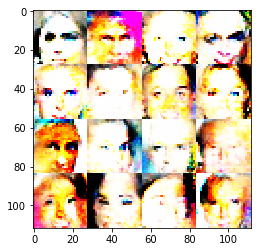

Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.7971... Generator Loss: 3.0806
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.9374
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 2.3628
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.3398


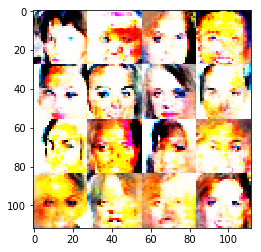

Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 2.1361
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 2.1600
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.8332
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.7232


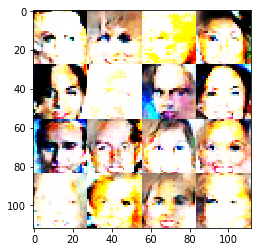

Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 2.2797
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 2.2855
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.7887
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 2.0039
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 2.0382


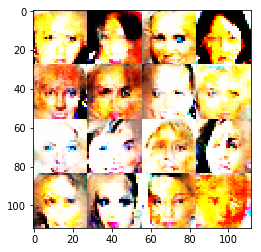

Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.9158
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 1.8345
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 3.2811
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.7211
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.8811


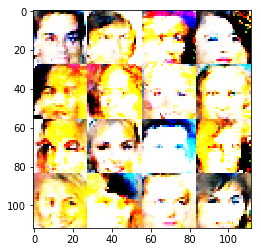

Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.5192
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 2.1747... Generator Loss: 2.9979


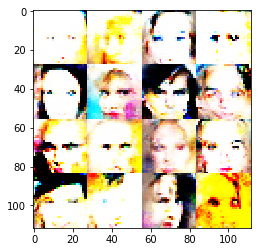

Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.8698
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.9639
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 3.2481


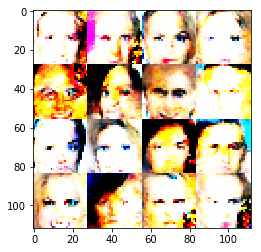

Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 2.7190
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 2.5621


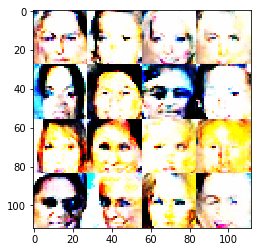

Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 2.0603
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 3.4803
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.6076


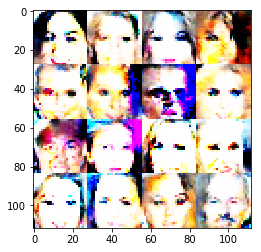

Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.1427
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 2.1487
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.8937


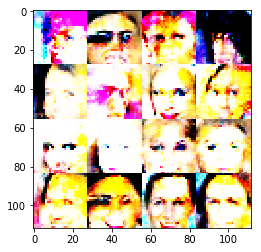

Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.4657
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 2.0501
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 2.5243
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.9715
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 0.9026


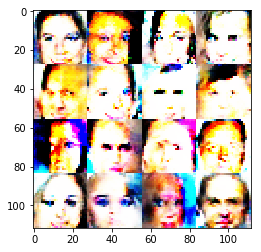

Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.9090
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.5626
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.2792


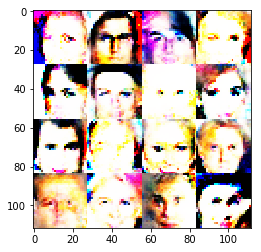

Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.3423
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.3681


In [45]:
batch_size = 16
z_dim = 100
learning_rate = 0.0007
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.